### METADATA

**Identifiers and Study Design**
- PatientID → unique patient code
- Group → study group:
    CR = corticosteroid-resistant asthmatics
    CS = corticosteroid-sensitive asthmatics
    Healthy = healthy controls
- Part → study part: A or B (Part B only for CR patients)
- RandomizationArm → treatment during crossover: AZD7624, Placebo, or None (if not in treatment block).
- Visit → study visit name:
    CR: Baseline, PostPrednisone, Week4_Block1, Washout, Week4_Block2
    CS: Baseline, PostPrednisone
    Healthy: Baseline
- TreatmentBlock → treatment phase in crossover (1 or 2, only for CR)

**Demographics**
- Age, in years
- Sex - M or F
- BMI, in kg/m2

**Lung Function / Spirometry**
- FEV1_percent_predicted → Forced Expiratory Volume in 1 second (% predicted for age/sex/height).
    Lower in CR (~65–75%).
    Higher in CS (~75–85%).
    Near normal in Healthy (~95%).
- Bronchodilator_Response_% → percent improvement in FEV1 after bronchodilator:
    CR: typically <10%.
    CS: typically >12%.
    Healthy: not measured (NaN)

**Biomarkers (Inflammatory / MAPK Pathway)**
- p38_MAPK_Blood → mean fluorescence intensity (MFI) of phosphorylated p38 MAPK in blood (by flow cytometry)
- p38_MAPK_BAL → MAPK activity in bronchoalveolar lavage (only for CR, Part B, during bronchoscopy)
- p38_MAPK_Sputum → MAPK activity in induced sputum (only for CR, Part B, crossover visits)
- CRP → C-reactive protein (mg/L), systemic inflammation marker

**Clinical Outcomes**
- Asthma_Control_Score → Asthma Control Test (ACT), 5–25 scale:
    - Lower in CR (10–16)
    - Higher in CS (18–22)
    - Very high in Healthy (22–25)
- AdverseEvent → Yes/No for any adverse event at that visit.

### Creating a dummy dataset for a clinical trial description following ClinicalTrials.gov's ID NCT02753764

import pandas as pd
import numpy as np
import random

def generate_clinical_trial_dataset(seed=42):
    np.random.seed(seed)
    random.seed(seed)

    n_CR, n_CS, n_HC = 10, 10, 10
    CR_ids = [f"CR{i+1:02d}" for i in range(n_CR)]
    CS_ids = [f"CS{i+1:02d}" for i in range(n_CS)]
    HC_ids = [f"HC{i+1:02d}" for i in range(n_HC)]

    visits_CR = ["Baseline", "PostPrednisone", "Week4_Block1", "Washout", "Week4_Block2"]
    visits_CS = ["Baseline", "PostPrednisone"]
    visits_HC = ["Baseline"]

    def gen_demo():
        return np.random.randint(18, 65), np.random.choice(["M", "F"]), round(np.random.uniform(20, 35), 1)

    def gen_patient_rows(pid, group):
        age, sex, bmi = gen_demo()
        rows = []
        if group == "CR":
            order = np.random.choice(["AZD7624_first", "Placebo_first"])
            for v in visits_CR:
                if v in ["Baseline", "PostPrednisone"]:
                    part, arm, block = "A", None, None
                elif v == "Week4_Block1":
                    part, block = "B", 1
                    arm = "AZD7624" if order == "AZD7624_first" else "Placebo"
                elif v == "Washout":
                    part, arm, block = "B", None, None
                else:  # Week4_Block2
                    part, block = "B", 2
                    arm = "Placebo" if order == "AZD7624_first" else "AZD7624"

                fev1 = round(np.random.normal(70, 5), 1)
                broncho = np.random.randint(4, 9)
                p38_blood = round(np.random.uniform(2.0, 3.5), 2)
                p38_bal = round(np.random.uniform(1.5, 3.0), 2) if "Week4" in v else np.nan
                p38_sputum = round(np.random.uniform(2.0, 3.5), 2) if "Week4" in v else np.nan
                crp = round(np.random.uniform(3.0, 6.0), 1)
                act = np.random.randint(10, 17)
                ae = np.random.choice(["Yes", "No"], p=[0.2, 0.8])

                rows.append([pid, group, part, arm, v, block, age, sex, bmi,
                             fev1, broncho, p38_blood, p38_bal, p38_sputum,
                             crp, act, ae])

        elif group == "CS":
            for v in visits_CS:
                fev1 = round(np.random.normal(80, 5), 1)
                broncho = np.random.randint(12, 20)
                p38_blood = round(np.random.uniform(0.8, 1.5), 2)
                crp = round(np.random.uniform(2.0, 4.0), 1)
                act = np.random.randint(18, 23)
                ae = "No"
                rows.append([pid, group, "A", None, v, None, age, sex, bmi,
                             fev1, broncho, p38_blood, np.nan, np.nan,
                             crp, act, ae])

        else:  # Healthy
            for v in visits_HC:
                fev1 = round(np.random.normal(95, 3), 1)
                broncho = np.nan
                p38_blood = round(np.random.uniform(0.7, 1.2), 2)
                crp = round(np.random.uniform(0.5, 2.0), 1)
                act = np.random.randint(22, 25)
                ae = "No"
                rows.append([pid, group, "A", None, v, None, age, sex, bmi,
                             fev1, broncho, p38_blood, np.nan, np.nan,
                             crp, act, ae])
        return rows

    all_rows = []
    for pid in CR_ids: all_rows.extend(gen_patient_rows(pid, "CR"))
    for pid in CS_ids: all_rows.extend(gen_patient_rows(pid, "CS"))
    for pid in HC_ids: all_rows.extend(gen_patient_rows(pid, "Healthy"))

    columns = ["PatientID", "Group", "Part", "RandomizationArm", "Visit", "TreatmentBlock",
               "Age", "Sex", "BMI", "FEV1_percent_predicted", "Bronchodilator_Response_%",
               "p38_MAPK_Blood", "p38_MAPK_BAL", "p38_MAPK_Sputum", "CRP",
               "Asthma_Control_Score", "AdverseEvent"]

    return pd.DataFrame(all_rows, columns=columns)


df = generate_clinical_trial_dataset()
df.to_csv("clinical_trial_dummy.csv", index=False)
df.head()

## SET UP NOTEBOOK and LOAD RESOURCES

In [72]:
# Import libraries

import pandas as pd
import numpy as np

In [73]:
# Open data file

df = pd.read_csv("clinical_trial_dummy.csv")

In [74]:
df.head()

,PatientID,Group,Part,RandomizationArm,Visit,TreatmentBlock,Age,Sex,BMI,FEV1_percent_predicted,Bronchodilator_Response_%,p38_MAPK_Blood,p38_MAPK_BAL,p38_MAPK_Sputum,CRP,Asthma_Control_Score,AdverseEvent
0,CR01,CR,A,NaN,Baseline,NaN,56,F,34.3,72.4,5.0,2.23,NaN,NaN,3.2,14,No
1,CR01,CR,A,NaN,PostPrednisone,NaN,56,F,34.3,76.8,6.0,2.03,NaN,NaN,5.9,13,No
2,CR01,CR,B,AZD7624,Week4_Block1,1.0,56,F,34.3,77.3,8.0,2.65,1.94,2.92,3.4,13,No
3,CR01,CR,B,NaN,Washout,NaN,56,F,34.3,77.7,6.0,2.57,NaN,NaN,5.9,10,Yes
4,CR01,CR,B,Placebo,Week4_Block2,2.0,56,F,34.3,64.2,5.0,3.42,2.95,3.21,3.9,14,No


In [75]:
df.shape

(80, 17)

## DATA PREPARATION

In [76]:
# check for missing data

df_missing = df.isna().sum()
df_missing

PatientID                     0
Group                         0
Part                          0
RandomizationArm             60
Visit                         0
TreatmentBlock               60
Age                           0
Sex                           0
BMI                           0
FEV1_percent_predicted        0
Bronchodilator_Response_%    10
p38_MAPK_Blood                0
p38_MAPK_BAL                 60
p38_MAPK_Sputum              60
CRP                           0
Asthma_Control_Score          0
AdverseEvent                  0
dtype: int64

### Reason for missing values

- RandomizationArm → NaN if not in treatment block
- TreatmentBlock → treatment phase in crossover (1 or 2, only for CR) - NaN if not CR
- Bronchodilator_Response_% → percent improvement in FEV1 after bronchodilator: Healthy: not measured (NaN)
- p38_MAPK_BAL → MAPK activity in bronchoalveolar lavage (only for CR, Part B, during bronchoscopy) - NaN if not CR
- p38_MAPK_Sputum → MAPK activity in induced sputum (only for CR, Part B, crossover visits) - NaN if not CR

All missing values appear to be reasonable.

In [77]:
# check for duplicate data

df_duplicate_count = df.duplicated().sum()
print("Number of duplicate rows:", df_duplicate_count)

Number of duplicate rows: 0


In [78]:
# Check and fix dtypes

df.dtypes

PatientID                     object
Group                         object
Part                          object
RandomizationArm              object
Visit                         object
TreatmentBlock               float64
Age                            int64
Sex                           object
BMI                          float64
FEV1_percent_predicted       float64
Bronchodilator_Response_%    float64
p38_MAPK_Blood               float64
p38_MAPK_BAL                 float64
p38_MAPK_Sputum              float64
CRP                          float64
Asthma_Control_Score           int64
AdverseEvent                  object
dtype: object

Set certain columns into categorical datatype.

In [79]:
object_dtype = ['PatientID']
category_dtype = ['Group', 'Part', 'RandomizationArm', 'Visit', 'TreatmentBlock', 'Sex', 'AdverseEvent']
int_type = ['Age', 'Asthma_Control_Score']
float_type = ['BMI', 'FEV1_percent_predicted', 'Bronchodilator_Response_%', 'p38_MAPK_Blood', 'p38_MAPK_BAL', 'p38_MAPK_Sputum', 'CRP']

In [80]:
# Apply conversions
df[object_dtype] = df[object_dtype].astype(str)

for col in category_dtype:
    df[col] = df[col].astype("category")

for col in int_type:
    df[col] = pd.to_numeric(df[col], errors="coerce").astype("Int64")  # Nullable int

for col in float_type:
    df[col] = pd.to_numeric(df[col], errors="coerce").astype("float64")

In [81]:
# Check results
df.dtypes

PatientID                      object
Group                        category
Part                         category
RandomizationArm             category
Visit                        category
TreatmentBlock               category
Age                             Int64
Sex                          category
BMI                           float64
FEV1_percent_predicted        float64
Bronchodilator_Response_%     float64
p38_MAPK_Blood                float64
p38_MAPK_BAL                  float64
p38_MAPK_Sputum               float64
CRP                           float64
Asthma_Control_Score            Int64
AdverseEvent                 category
dtype: object

## DESCRIPTIVE STATISTICS

In [82]:
# Multiple tables for frequency

for col in category_dtype:
    print(f"\nFrequency table for {col}:")
    freq_table = df[col].value_counts().reset_index()
    freq_table.columns = [col, "Frequency"]
    print(freq_table)


Frequency table for Group:
     Group  Frequency
0       CR         50
1       CS         20
2  Healthy         10

Frequency table for Part:
  Part  Frequency
0    A         50
1    B         30

Frequency table for RandomizationArm:
  RandomizationArm  Frequency
0          AZD7624         10
1          Placebo         10

Frequency table for Visit:
            Visit  Frequency
0        Baseline         30
1  PostPrednisone         20
2         Washout         10
3    Week4_Block1         10
4    Week4_Block2         10

Frequency table for TreatmentBlock:
  TreatmentBlock  Frequency
0            1.0         10
1            2.0         10

Frequency table for Sex:
  Sex  Frequency
0   F         43
1   M         37

Frequency table for AdverseEvent:
  AdverseEvent  Frequency
0           No         72
1          Yes          8


Visit    Baseline  PostPrednisone  Washout  Week4_Block1  Week4_Block2
Group                                                                 
CR             10              10       10            10            10
CS             10              10        0             0             0
Healthy        10               0        0             0             0


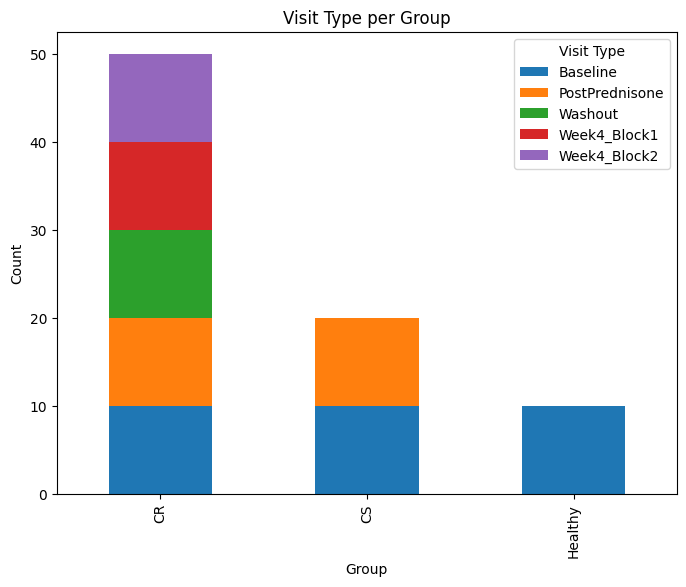

In [83]:
#Stacked bar chart for Group and Visit type

import matplotlib.pyplot as plt


# Create frequency table (pivot table)
Visit_per_group = pd.crosstab(df['Group'], df['Visit'])

print(Visit_per_group)

# Plot stacked bar chart
Visit_per_group.plot(kind='bar', stacked=True, figsize=(8,6))

plt.title("Visit Type per Group")
plt.xlabel("Group")
plt.ylabel("Count")
plt.legend(title="Visit Type")
plt.show()

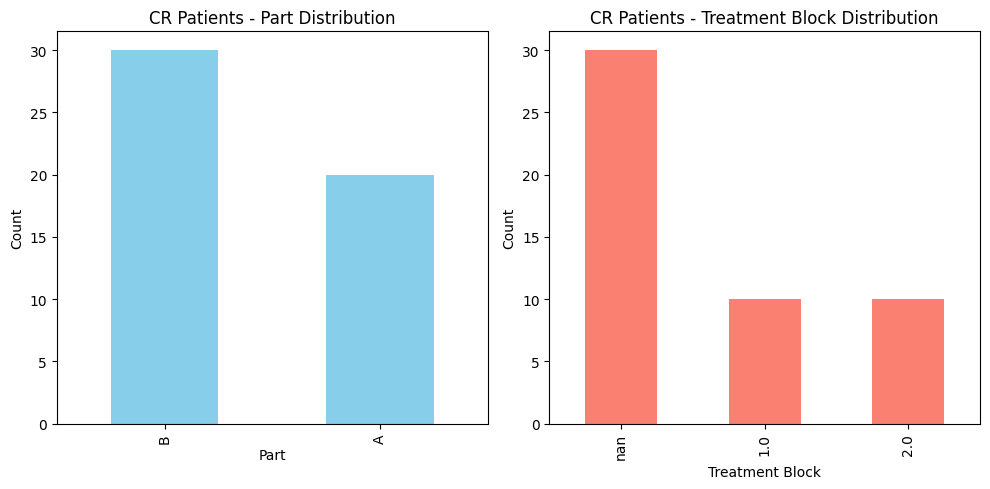

In [84]:
# Filter CR patients
df_cr = df[df['Group'] == 'CR'][['PatientID', 'Part', 'TreatmentBlock']]

# Plot side-by-side bar charts
fig, axes = plt.subplots(1, 2, figsize=(10,5))

# Part distribution
part_counts.plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title("CR Patients - Part Distribution")
axes[0].set_xlabel("Part")
axes[0].set_ylabel("Count")

# TreatmentBlock distribution
tblock_counts.plot(kind='bar', ax=axes[1], color='salmon')
axes[1].set_title("CR Patients - Treatment Block Distribution")
axes[1].set_xlabel("Treatment Block")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


In [ ]:
# BMI classification

bmi_bins = [0, 18.5, 24.9, 29.9, float('inf')]
bmi_labels = ["Underweight", "Healthy", "Overweight", "Obesity"]
# Create new column for BMI Category
df['BMI_Category'] = pd.cut(df['BMI'], bins=bmi_bins, labels=bmi_labels, right=True)

# Check result
df.head()

,PatientID,Group,Part,RandomizationArm,Visit,TreatmentBlock,Age,Sex,BMI,FEV1_percent_predicted,Bronchodilator_Response_%,p38_MAPK_Blood,p38_MAPK_BAL,p38_MAPK_Sputum,CRP,Asthma_Control_Score,AdverseEvent,BMI_Category
0,CR01,CR,A,NaN,Baseline,NaN,56,F,34.3,72.4,5.0,2.23,NaN,NaN,3.2,14,No,Obesity
1,CR01,CR,A,NaN,PostPrednisone,NaN,56,F,34.3,76.8,6.0,2.03,NaN,NaN,5.9,13,No,Obesity
2,CR01,CR,B,AZD7624,Week4_Block1,1.0,56,F,34.3,77.3,8.0,2.65,1.94,2.92,3.4,13,No,Obesity
3,CR01,CR,B,NaN,Washout,NaN,56,F,34.3,77.7,6.0,2.57,NaN,NaN,5.9,10,Yes,Obesity
4,CR01,CR,B,Placebo,Week4_Block2,2.0,56,F,34.3,64.2,5.0,3.42,2.95,3.21,3.9,14,No,Obesity


  BMI_Category  Frequency
0      Obesity         49
1   Overweight         19
2      Healthy         12
3  Underweight          0


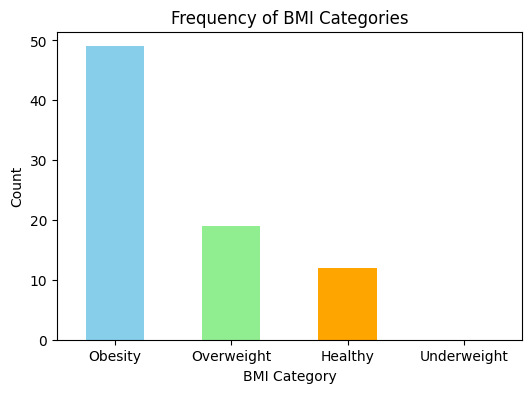

In [ ]:
# Frequency table for BMI
bmi_freq = df['BMI_Category'].value_counts().reset_index()
bmi_freq.columns = ['BMI_Category', 'Frequency']
print(bmi_freq)

# Bar chart
df['BMI_Category'].value_counts().plot(
    kind='bar',
    color=['skyblue', 'lightgreen', 'orange', 'red'],
    figsize=(6,4)
)

plt.title("Frequency of BMI Categories")
plt.xlabel("BMI Category")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()


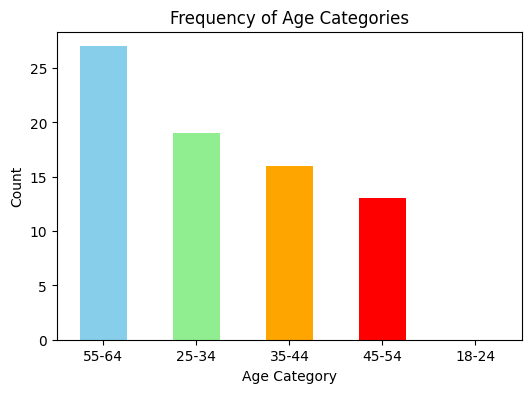

In [103]:
# Age Classification - Decade
age_bins = [18, 24, 34, 44, 54, 64]
age_labels = ["18-24", "25-34", "35-44", "45-54", "55-64"]

df['Age_Group'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=True)

# Bar chart
df['Age_Group'].value_counts().plot(
    kind='bar',
    color=['skyblue', 'lightgreen', 'orange', 'red', 'yellow'],
    figsize=(6,4)
)

plt.title("Frequency of Age Categories")
plt.xlabel("Age Category")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()


In [104]:
# Describe numerical data

df.describe()

,Age,BMI,FEV1_percent_predicted,Bronchodilator_Response_%,p38_MAPK_Blood,p38_MAPK_BAL,p38_MAPK_Sputum,CRP,Asthma_Control_Score
count,80.0,80.000000,80.000000,70.000000,80.000000,20.00000,20.000000,80.000000,80.0
mean,42.8,29.602500,76.721250,8.585714,2.168000,2.29850,2.731000,3.710000,15.8875
std,12.937435,3.622503,9.467141,4.447741,0.925361,0.43335,0.402269,1.348661,4.339964
min,18.0,21.100000,60.300000,4.000000,0.720000,1.51000,2.060000,0.700000,10.0
25%,33.0,25.975000,70.000000,5.000000,1.187500,2.00750,2.410000,3.100000,12.0
50%,44.0,30.400000,75.400000,7.000000,2.360000,2.36500,2.670000,3.700000,15.0
75%,56.0,32.600000,80.075000,12.750000,3.017500,2.61250,3.060000,4.625000,20.0
max,64.0,34.800000,100.600000,18.000000,3.470000,2.95000,3.360000,5.900000,24.0


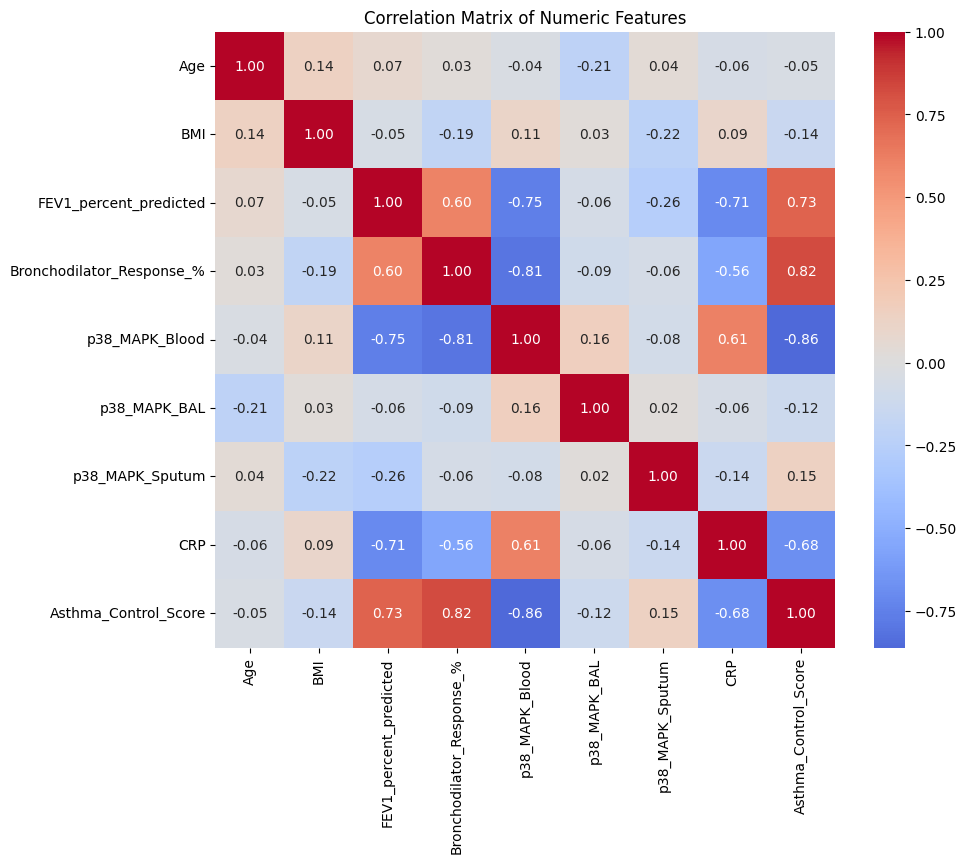

In [ ]:
# Correlation matrix for non-numerical data

import seaborn as sns

# Select only numeric columns
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Display correlation matrix
corr_matrix

# Plot heatmap for better visualization
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Correlation Matrix of Numeric Features")
plt.show()

Significant correlation (60%)
- FEV1_percent_predicted and Bronchodilator_Response_% (P), p38_MAPK_Blood (N), CRP (N), Asthma_control_source (P)
- Bronchodilator_Response_% and FEV1_percent_predicted (P), p38_MAPK_Blood (N), Asthma_control_source (P)
- p38_MAPK_Blood and FEV1_percent_predicted (N), Bronchodilator_Response_% (N), CRP (P), Asthma_control_source (N)
- CRP and FEV1_percent_predicted (N), p38_MAPK_Blood (P), Asthma_control_source (N)
- Asthma_control_source and FEV1_percent_predicted (P), Bronchodilator_Response_% (P), p38_MAPK_Blood (N), CRP (N)

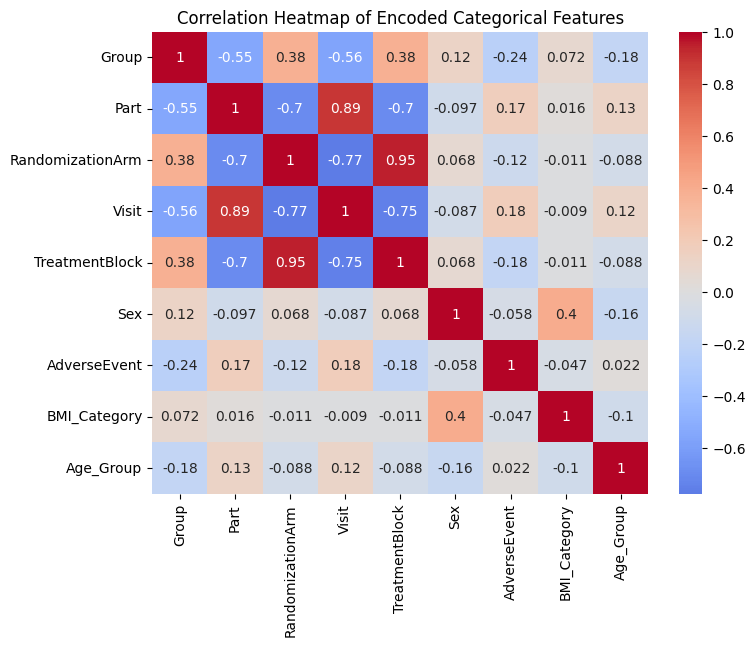

In [110]:
from sklearn.preprocessing import LabelEncoder

# Copy dataset
df_encoded = df.copy()

# Encode categorical columns
cat_cols = ['Group', 'Part', 'RandomizationArm', 'Visit', 'TreatmentBlock', 'Sex', 'AdverseEvent', 'BMI_Category', 'Age_Group']
le = LabelEncoder()
for col in cat_cols:
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))  # handle NaN as string

# Correlation
corr_cat = df_encoded[cat_cols].corr()

# Heatmap

plt.figure(figsize=(8,6))
sns.heatmap(corr_cat, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Encoded Categorical Features")
plt.show()


In [112]:
df_encoded

,PatientID,Group,Part,RandomizationArm,Visit,TreatmentBlock,Age,Sex,BMI,FEV1_percent_predicted,Bronchodilator_Response_%,p38_MAPK_Blood,p38_MAPK_BAL,p38_MAPK_Sputum,CRP,Asthma_Control_Score,AdverseEvent,BMI_Category,Age_Group
0,CR01,0,0,2,0,2,56,0,34.3,72.4,5.0,2.23,NaN,NaN,3.2,14,0,1,3
1,CR01,0,0,2,1,2,56,0,34.3,76.8,6.0,2.03,NaN,NaN,5.9,13,0,1,3
2,CR01,0,1,0,3,0,56,0,34.3,77.3,8.0,2.65,1.94,2.92,3.4,13,0,1,3
3,CR01,0,1,2,2,2,56,0,34.3,77.7,6.0,2.57,NaN,NaN,5.9,10,1,1,3
4,CR01,0,1,1,4,1,56,0,34.3,64.2,5.0,3.42,2.95,3.21,3.9,14,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,HC06,2,0,2,0,2,45,0,27.0,93.2,NaN,0.88,NaN,NaN,1.4,22,0,2,2
76,HC07,2,0,2,0,2,58,0,34.8,96.0,NaN,0.85,NaN,NaN,1.7,22,0,1,3
77,HC08,2,0,2,0,2,30,0,21.1,100.6,NaN,1.17,NaN,NaN,1.1,22,0,0,0
78,HC09,2,0,2,0,2,64,1,26.3,98.5,NaN,1.19,NaN,NaN,0.7,22,0,2,3


## INFERENTIAL STATISTICS

In [ ]:
Boxplot: p38_MAPK_Blood by Group.
Lineplot: FEV1_percent_predicted across visits for CR patients.
Statistical Testing
Paired t-test: Baseline vs PostPrednisone FEV1 in CR vs CS.
ANOVA: MAPK blood levels across CR, CS, Healthy.
Regression
Linear regression: FEV1 ~ p38_MAPK_Blood + Age + BMI.
Logistic regression: AdverseEvent ~ TreatmentArm + CRP.
Machine Learning
Classification: Predict Group (CR vs CS vs Healthy) from biomarkers.
Clustering: Cluster patients by MAPK + CRP.
Data Wrangling
Reshape data from long (visits) → wide (one row per patient).
Handle missing data (BAL & Sputum NaN in non-CR).

SyntaxError: invalid character '→' (U+2192) (1262953852.py, line 13)